In [1]:
getwd()

[1] "C:/Users/bahad/GitHub/IE582/Homework3"

In [2]:
library(data.table)
library(lubridate, quietly=TRUE)
library(zoo, quietly = TRUE)
library(dplyr, quietly = TRUE)
library(glmnet)
library(MLmetrics)
library("mvtnorm") 
library(tidyr)
library(ggplot2)


Attaching package: 'lubridate'

The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

The following object is masked from 'package:base':

    date


Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:lubridate':

    intersect, setdiff, union

The following objects are masked from 'package:data.table':

    between, first, last

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16


Attaching package: 'MLmetrics'

The following object is masked from 'package:base':

    Recall

Warning message:


In [3]:
dt=fread("GercekZamanliTuketim-01012016-01122020.csv")
dt$Tarih=dmy(dt$Tarih)

In [4]:
setnames(dt, "Tüketim Miktarı (MWh)", "consumption")
setnames(dt, "Tarih", "date")
setnames(dt, "Saat", "hour")
dt$consumption=gsub('\\.', '', dt$consumption)
dt$consumption=gsub('\\,', '.', dt$consumption)
dt$hour=gsub(':00', '', dt$hour)

In [5]:
dt$consumption=as.numeric(dt$consumption)
dt$hour=as.numeric(dt$hour)
str(dt)

Classes 'data.table' and 'data.frame':	43128 obs. of  3 variables:
 $ date       : Date, format: "2016-01-01" "2016-01-01" ...
 $ hour       : num  0 1 2 3 4 5 6 7 8 9 ...
 $ consumption: num  26277 24992 23533 22465 22003 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [6]:
dt_lagged1=copy(dt)
dt_lagged1[, Lag_48:=shift(consumption,type="lag",n=48)]
dt_lagged1[, Lag_168:=shift(consumption,type="lag",n=168)]

In [7]:
train=filter(dt_lagged1,date<="2020-10-31")
#train

In [8]:
test=filter(dt_lagged1,date>"2020-10-31")
#test

In [9]:
MAPE_48=MAPE(test$consumption,test$Lag_48)
MAPE_48_values=abs(((test$consumption-test$Lag_48)/test$Lag_48))
print(paste("MAPE value for lag48 equals to:", MAPE_48))
MAPE_168=MAPE(test$consumption,test$Lag_168)
MAPE_168_values=abs(((test$consumption-test$Lag_168)/test$Lag_168))
print(paste("MAPE value for lag168 equals to:", MAPE_168))

[1] "MAPE value for lag48 equals to: 0.0818808509914842"
[1] "MAPE value for lag168 equals to: 0.0365111250910964"


# PART B

In [10]:
str(train)

Classes 'data.table' and 'data.frame':	42384 obs. of  5 variables:
 $ date       : Date, format: "2016-01-01" "2016-01-01" ...
 $ hour       : num  0 1 2 3 4 5 6 7 8 9 ...
 $ consumption: num  26277 24992 23533 22465 22003 ...
 $ Lag_48     : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Lag_168    : num  NA NA NA NA NA NA NA NA NA NA ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [11]:
Reg=lm(data=train, consumption~Lag_48+Lag_168)
summary(Reg)


Call:
lm(formula = consumption ~ Lag_48 + Lag_168, data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-25242.2   -984.2     -0.5   1016.9  16102.6 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.574e+03  8.353e+01   18.84   <2e-16 ***
Lag_48      3.084e-01  3.096e-03   99.60   <2e-16 ***
Lag_168     6.435e-01  3.094e-03  208.03   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2392 on 42213 degrees of freedom
  (168 observations deleted due to missingness)
Multiple R-squared:  0.7753,	Adjusted R-squared:  0.7753 
F-statistic: 7.281e+04 on 2 and 42213 DF,  p-value: < 2.2e-16


In [80]:
predictions=predict(Reg,newdata = test)
MAPE_reg=MAPE(predictions,test$consumption)
MAPE_reg_values=as.vector(abs(((test$consumption-predictions)/test$consumption)))
print(paste("MAPE value for autoregression model equals to:", MAPE_reg))

[1] "MAPE value for autoregression model equals to: 0.0422942770625392"


# PART C

In [13]:
names_train<-paste0("hour",0:23,"_train")
names_test<-paste0("hour",0:23,"_test")

In [14]:
train_split <- split(train, train$hour)
new_names_train <- names_train
for (i in 1:length(train_split)) {
  assign(new_names_train[i], train_split[[i]])
}

In [15]:
test_split <- split(test, test$hour)
new_names_test <- names_test
for (i in 1:length(test_split)) {
  assign(new_names_test[i], test_split[[i]])
}

## Models

In [16]:
mape_result_c=rep(0,24)

In [17]:
Reg0=lm(data=hour0_train, consumption~Lag_48+Lag_168)
summary(Reg0)
predictions0=predict(Reg0,newdata = hour0_test)
MAPE_0=MAPE(predictions0,hour0_test$consumption)
MAPE_0_values=as.vector(abs((hour0_test$consumption-predictions0)/length(test$consumption)))
MAPE0c_reg_values=as.vector(abs(((hour0_test$consumption-predictions0)/hour0_test$consumption)))
mape_result_c[1]<-MAPE_0
MAPE_0


Call:
lm(formula = consumption ~ Lag_48 + Lag_168, data = hour0_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-9164.8  -799.5    41.6   883.0  6407.1 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.191e+03  4.314e+02   5.079  4.2e-07 ***
Lag_48      4.869e-01  1.685e-02  28.889  < 2e-16 ***
Lag_168     4.428e-01  1.682e-02  26.329  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1591 on 1756 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.7209,	Adjusted R-squared:  0.7206 
F-statistic:  2268 on 2 and 1756 DF,  p-value: < 2.2e-16


[1] 0.03262965

In [18]:
Reg1=lm(data=hour1_train, consumption~Lag_48+Lag_168)
summary(Reg1)
predictions1=predict(Reg1,newdata = hour1_test)
MAPE_1=MAPE(predictions1,hour1_test$consumption)
MAPE_1_values=as.vector(abs((hour1_test$consumption-predictions1)/length(test$consumption)))
MAPE1c_reg_values=as.vector(abs(((hour1_test$consumption-predictions1)/hour1_test$consumption)))
mape_result_c[2]<-MAPE_1
MAPE_1


Call:
lm(formula = consumption ~ Lag_48 + Lag_168, data = hour1_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-9387.9  -774.5    76.6   832.3  6453.8 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.120e+03  4.130e+02   5.134 3.15e-07 ***
Lag_48      4.920e-01  1.687e-02  29.167  < 2e-16 ***
Lag_168     4.364e-01  1.683e-02  25.933  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1561 on 1756 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.717,	Adjusted R-squared:  0.7167 
F-statistic:  2225 on 2 and 1756 DF,  p-value: < 2.2e-16


[1] 0.03283087

In [19]:
Reg2=lm(data=hour2_train, consumption~Lag_48+Lag_168)
summary(Reg2)
predictions2=predict(Reg2,newdata = hour2_test)
MAPE_2=MAPE(predictions2,hour2_test$consumption)
MAPE_2_values=as.vector(abs((hour2_test$consumption-predictions2)/length(test$consumption)))
MAPE2c_reg_values=as.vector(abs(((hour2_test$consumption-predictions2)/hour2_test$consumption)))
mape_result_c[3]<-MAPE_2
MAPE_2


Call:
lm(formula = consumption ~ Lag_48 + Lag_168, data = hour2_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-25401.9   -788.9     71.8    841.5  12763.8 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.831e+03  4.429e+02   6.392 2.09e-10 ***
Lag_48      4.753e-01  1.773e-02  26.816  < 2e-16 ***
Lag_168     4.252e-01  1.768e-02  24.047  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1704 on 1756 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.6575,	Adjusted R-squared:  0.6571 
F-statistic:  1685 on 2 and 1756 DF,  p-value: < 2.2e-16


[1] 0.03405206

In [20]:
Reg3=lm(data=hour3_train, consumption~Lag_48+Lag_168)
summary(Reg3)
predictions3=predict(Reg3,newdata = hour3_test)
MAPE_3=MAPE(predictions3,hour3_test$consumption)
MAPE_3_values=as.vector(abs((hour3_test$consumption-predictions3)/length(test$consumption)))
MAPE3c_reg_values=as.vector(abs(((hour3_test$consumption-predictions3)/hour3_test$consumption)))
mape_result_c[4]<-MAPE_3
MAPE_3


Call:
lm(formula = consumption ~ Lag_48 + Lag_168, data = hour3_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-8870.5  -817.7    66.7   871.5  6271.5 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.229e+03  4.079e+02   5.463 5.34e-08 ***
Lag_48      4.928e-01  1.704e-02  28.913  < 2e-16 ***
Lag_168     4.270e-01  1.700e-02  25.112  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1521 on 1755 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.6918,	Adjusted R-squared:  0.6915 
F-statistic:  1970 on 2 and 1755 DF,  p-value: < 2.2e-16


[1] 0.03202694

In [21]:
Reg4=lm(data=hour4_train, consumption~Lag_48+Lag_168)
summary(Reg4)
predictions4=predict(Reg4,newdata = hour4_test)
MAPE_4=MAPE(predictions4,hour4_test$consumption)
MAPE_4_values=as.vector(abs((hour4_test$consumption-predictions4)/length(test$consumption)))
MAPE4c_reg_values=as.vector(abs(((hour4_test$consumption-predictions4)/hour4_test$consumption)))
mape_result_c[5]<-MAPE_4
MAPE_4


Call:
lm(formula = consumption ~ Lag_48 + Lag_168, data = hour4_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-7887.2  -802.8    42.3   861.0  6287.8 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.205e+03  4.096e+02   5.384 8.25e-08 ***
Lag_48      4.747e-01  1.696e-02  27.990  < 2e-16 ***
Lag_168     4.449e-01  1.691e-02  26.320  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1495 on 1757 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.6843,	Adjusted R-squared:  0.6839 
F-statistic:  1904 on 2 and 1757 DF,  p-value: < 2.2e-16


[1] 0.03183032

In [22]:
Reg5=lm(data=hour5_train, consumption~Lag_48+Lag_168)
summary(Reg5)
predictions5=predict(Reg5,newdata = hour5_test)
MAPE_5=MAPE(predictions5,hour5_test$consumption)
MAPE_5_values=as.vector(abs((hour5_test$consumption-predictions5)/length(test$consumption)))
MAPE5c_reg_values=as.vector(abs(((hour5_test$consumption-predictions5)/hour5_test$consumption)))
mape_result_c[6]<-MAPE_5
MAPE_5


Call:
lm(formula = consumption ~ Lag_48 + Lag_168, data = hour5_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-7438.7  -778.2    34.5   839.2  6380.3 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.225e+03  4.192e+02   5.308 1.25e-07 ***
Lag_48      4.399e-01  1.689e-02  26.044  < 2e-16 ***
Lag_168     4.785e-01  1.685e-02  28.401  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1486 on 1756 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.6705,	Adjusted R-squared:  0.6701 
F-statistic:  1787 on 2 and 1756 DF,  p-value: < 2.2e-16


[1] 0.0318745

In [23]:
Reg6=lm(data=hour6_train, consumption~Lag_48+Lag_168)
summary(Reg6)
predictions6=predict(Reg6,newdata = hour6_test)
MAPE_6=MAPE(predictions6,hour6_test$consumption)
MAPE_6_values=as.vector(abs((hour6_test$consumption-predictions6)/length(test$consumption)))
MAPE6c_reg_values=as.vector(abs(((hour6_test$consumption-predictions6)/hour6_test$consumption)))
mape_result_c[7]<-MAPE_6
MAPE_6


Call:
lm(formula = consumption ~ Lag_48 + Lag_168, data = hour6_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-7426.1  -729.0    37.6   849.3  7049.2 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.127e+03  4.246e+02    5.01    6e-07 ***
Lag_48      3.760e-01  1.651e-02   22.77   <2e-16 ***
Lag_168     5.462e-01  1.648e-02   33.15   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1565 on 1756 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.6704,	Adjusted R-squared:   0.67 
F-statistic:  1786 on 2 and 1756 DF,  p-value: < 2.2e-16


[1] 0.03148057

In [24]:
Reg7=lm(data=hour7_train, consumption~Lag_48+Lag_168)
summary(Reg7)
predictions7=predict(Reg7,newdata = hour7_test)
MAPE_7=MAPE(predictions7,hour7_test$consumption)
MAPE_7_values=as.vector(abs((hour7_test$consumption-predictions7)/length(test$consumption)))
MAPE7c_reg_values=as.vector(abs(((hour7_test$consumption-predictions7)/hour7_test$consumption)))
mape_result_c[8]<-MAPE_7
MAPE_7


Call:
lm(formula = consumption ~ Lag_48 + Lag_168, data = hour7_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-8817.9  -806.9    65.1   933.5  8965.0 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.311e+03  4.726e+02   4.889 1.11e-06 ***
Lag_48      2.663e-01  1.568e-02  16.982  < 2e-16 ***
Lag_168     6.528e-01  1.565e-02  41.714  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1915 on 1756 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.6542,	Adjusted R-squared:  0.6539 
F-statistic:  1661 on 2 and 1756 DF,  p-value: < 2.2e-16


[1] 0.03776119

In [25]:
Reg8=lm(data=hour8_train, consumption~Lag_48+Lag_168)
summary(Reg8)
predictions8=predict(Reg8,newdata = hour8_test)
MAPE_8=MAPE(predictions8,hour8_test$consumption)
MAPE_8_values=as.vector(abs((hour8_test$consumption-predictions8)/length(test$consumption)))
MAPE8c_reg_values=as.vector(abs(((hour8_test$consumption-predictions8)/hour8_test$consumption)))
mape_result_c[9]<-MAPE_8
MAPE_8


Call:
lm(formula = consumption ~ Lag_48 + Lag_168, data = hour8_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-13443.6  -1020.6    132.4   1181.9  13089.0 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.233e+03  6.051e+02   5.343 1.03e-07 ***
Lag_48      1.737e-01  1.518e-02  11.441  < 2e-16 ***
Lag_168     7.255e-01  1.516e-02  47.852  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2709 on 1756 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.6178,	Adjusted R-squared:  0.6173 
F-statistic:  1419 on 2 and 1756 DF,  p-value: < 2.2e-16


[1] 0.0467235

In [26]:
Reg9=lm(data=hour9_train, consumption~Lag_48+Lag_168)
summary(Reg9)
predictions9=predict(Reg9,newdata = hour9_test)
MAPE_9=MAPE(predictions9,hour9_test$consumption)
MAPE_9_values=as.vector(abs((hour9_test$consumption-predictions9)/length(test$consumption)))
MAPE9c_reg_values=as.vector(abs(((hour9_test$consumption-predictions9)/hour9_test$consumption)))
mape_result_c[10]<-MAPE_9
MAPE_9


Call:
lm(formula = consumption ~ Lag_48 + Lag_168, data = hour9_train)

Residuals:
   Min     1Q Median     3Q    Max 
-15683  -1301    118   1346  15023 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.595e+03  6.557e+02   5.482 4.81e-08 ***
Lag_48      1.744e-01  1.534e-02  11.365  < 2e-16 ***
Lag_168     7.207e-01  1.533e-02  47.005  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3060 on 1756 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.609,	Adjusted R-squared:  0.6085 
F-statistic:  1367 on 2 and 1756 DF,  p-value: < 2.2e-16


[1] 0.05484825

In [27]:
Reg10=lm(data=hour10_train, consumption~Lag_48+Lag_168)
summary(Reg10)
predictions10=predict(Reg10,newdata = hour10_test)
MAPE_10=MAPE(predictions10,hour10_test$consumption)
MAPE_10_values=as.vector(abs((hour10_test$consumption-predictions10)/length(test$consumption)))
MAPE10c_reg_values=as.vector(abs(((hour10_test$consumption-predictions10)/hour10_test$consumption)))
mape_result_c[11]<-MAPE_10
MAPE_10


Call:
lm(formula = consumption ~ Lag_48 + Lag_168, data = hour10_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-16524.5  -1360.2     95.7   1449.3  15554.3 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.741e+03  6.679e+02   5.601 2.47e-08 ***
Lag_48      2.062e-01  1.584e-02  13.019  < 2e-16 ***
Lag_168     6.869e-01  1.584e-02  43.376  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3080 on 1756 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.5952,	Adjusted R-squared:  0.5948 
F-statistic:  1291 on 2 and 1756 DF,  p-value: < 2.2e-16


[1] 0.06087343

In [28]:
Reg11=lm(data=hour11_train, consumption~Lag_48+Lag_168)
summary(Reg11)
predictions11=predict(Reg11,newdata = hour11_test)
MAPE_11=MAPE(predictions11,hour11_test$consumption)
MAPE_11_values=as.vector(abs((hour11_test$consumption-predictions11)/length(test$consumption)))
MAPE11c_reg_values=as.vector(abs(((hour11_test$consumption-predictions11)/hour11_test$consumption)))
mape_result_c[12]<-MAPE_11
MAPE_11


Call:
lm(formula = consumption ~ Lag_48 + Lag_168, data = hour11_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-17064.1  -1439.9     89.1   1517.4  15685.0 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3958.7062   685.0264   5.779 8.88e-09 ***
Lag_48         0.2250     0.0162  13.886  < 2e-16 ***
Lag_168        0.6636     0.0162  40.954  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3128 on 1756 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.5816,	Adjusted R-squared:  0.5811 
F-statistic:  1220 on 2 and 1756 DF,  p-value: < 2.2e-16


[1] 0.06273932

In [29]:
Reg12=lm(data=hour12_train, consumption~Lag_48+Lag_168)
summary(Reg12)
predictions12=predict(Reg12,newdata = hour12_test)
MAPE_12=MAPE(predictions12,hour12_test$consumption)
MAPE_12_values=as.vector(abs((hour12_test$consumption-predictions12)/length(test$consumption)))
MAPE12c_reg_values=as.vector(abs(((hour12_test$consumption-predictions12)/hour12_test$consumption)))
mape_result_c[13]<-MAPE_12
MAPE_12


Call:
lm(formula = consumption ~ Lag_48 + Lag_168, data = hour12_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-15478.0  -1435.0     38.3   1514.4  14612.1 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.662e+03  6.320e+02   5.794 8.11e-09 ***
Lag_48      2.802e-01  1.664e-02  16.836  < 2e-16 ***
Lag_168     6.131e-01  1.665e-02  36.829  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2871 on 1756 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.5912,	Adjusted R-squared:  0.5908 
F-statistic:  1270 on 2 and 1756 DF,  p-value: < 2.2e-16


[1] 0.065443

In [30]:
Reg13=lm(data=hour13_train, consumption~Lag_48+Lag_168)
summary(Reg13)
predictions13=predict(Reg13,newdata = hour13_test)
MAPE_13=MAPE(predictions13,hour13_test$consumption)
MAPE_13_values=as.vector(abs((hour13_test$consumption-predictions13)/length(test$consumption)))
MAPE13c_reg_values=as.vector(abs(((hour13_test$consumption-predictions13)/hour13_test$consumption)))
mape_result_c[14]<-MAPE_13
MAPE_13


Call:
lm(formula = consumption ~ Lag_48 + Lag_168, data = hour13_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-15516.6  -1455.5    -52.5   1531.0  14805.7 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.807e+03  6.426e+02   5.924 3.78e-09 ***
Lag_48      3.035e-01  1.691e-02  17.946  < 2e-16 ***
Lag_168     5.868e-01  1.692e-02  34.691  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2942 on 1756 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.5828,	Adjusted R-squared:  0.5824 
F-statistic:  1227 on 2 and 1756 DF,  p-value: < 2.2e-16


[1] 0.06684703

In [31]:
Reg14=lm(data=hour14_train, consumption~Lag_48+Lag_168)
summary(Reg14)
predictions14=predict(Reg14,newdata = hour14_test)
MAPE_14=MAPE(predictions14,hour14_test$consumption)
MAPE_14_values=as.vector(abs((hour14_test$consumption-predictions14)/length(test$consumption)))
MAPE14c_reg_values=as.vector(abs(((hour14_test$consumption-predictions14)/hour14_test$consumption)))
mape_result_c[15]<-MAPE_14
MAPE_14


Call:
lm(formula = consumption ~ Lag_48 + Lag_168, data = hour14_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-16080.5  -1558.9    -23.7   1657.2  15598.5 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 4.067e+03  6.845e+02   5.941 3.41e-09 ***
Lag_48      2.597e-01  1.665e-02  15.595  < 2e-16 ***
Lag_168     6.256e-01  1.665e-02  37.565  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3162 on 1756 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.5688,	Adjusted R-squared:  0.5683 
F-statistic:  1158 on 2 and 1756 DF,  p-value: < 2.2e-16


[1] 0.06481529

In [32]:
Reg15=lm(data=hour15_train, consumption~Lag_48+Lag_168)
summary(Reg15)
predictions15=predict(Reg15,newdata = hour15_test)
MAPE_15=MAPE(predictions15,hour15_test$consumption)
MAPE_15_values=as.vector(abs((hour15_test$consumption-predictions15)/length(test$consumption)))
MAPE15c_reg_values=as.vector(abs(((hour15_test$consumption-predictions15)/hour15_test$consumption)))
mape_result_c[16]<-MAPE_15
MAPE_15


Call:
lm(formula = consumption ~ Lag_48 + Lag_168, data = hour15_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-15892.2  -1536.9     29.2   1579.0  15347.2 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.951e+03  6.776e+02   5.831 6.56e-09 ***
Lag_48      2.564e-01  1.654e-02  15.505  < 2e-16 ***
Lag_168     6.319e-01  1.653e-02  38.225  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3121 on 1756 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.5752,	Adjusted R-squared:  0.5747 
F-statistic:  1189 on 2 and 1756 DF,  p-value: < 2.2e-16


[1] 0.06083015

In [33]:
Reg16=lm(data=hour16_train, consumption~Lag_48+Lag_168)
summary(Reg16)
predictions16=predict(Reg16,newdata = hour16_test)
MAPE_16=MAPE(predictions16,hour16_test$consumption)
MAPE_16_values=as.vector(abs((hour16_test$consumption-predictions16)/length(test$consumption)))
MAPE16c_reg_values=as.vector(abs(((hour16_test$consumption-predictions16)/hour16_test$consumption)))
mape_result_c[17]<-MAPE_16
MAPE_16


Call:
lm(formula = consumption ~ Lag_48 + Lag_168, data = hour16_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-15324.5  -1471.0     40.2   1513.4  15030.9 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.816e+03  6.732e+02   5.668 1.69e-08 ***
Lag_48      2.471e-01  1.632e-02  15.146  < 2e-16 ***
Lag_168     6.456e-01  1.631e-02  39.581  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3034 on 1756 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.5857,	Adjusted R-squared:  0.5852 
F-statistic:  1241 on 2 and 1756 DF,  p-value: < 2.2e-16


[1] 0.05147396

In [34]:
Reg17=lm(data=hour17_train, consumption~Lag_48+Lag_168)
summary(Reg17)
predictions17=predict(Reg17,newdata = hour17_test)
MAPE_17=MAPE(predictions17,hour17_test$consumption)
MAPE_17_values=as.vector(abs((hour17_test$consumption-predictions17)/length(test$consumption)))
MAPE17c_reg_values=as.vector(abs(((hour17_test$consumption-predictions17)/hour17_test$consumption)))
mape_result_c[18]<-MAPE_17
MAPE_17


Call:
lm(formula = consumption ~ Lag_48 + Lag_168, data = hour17_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-14128.0  -1329.5     33.5   1374.4  13313.9 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3389.9375   638.1515   5.312 1.22e-07 ***
Lag_48         0.2621     0.0161  16.277  < 2e-16 ***
Lag_168        0.6431     0.0161  39.946  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2757 on 1756 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.615,	Adjusted R-squared:  0.6146 
F-statistic:  1403 on 2 and 1756 DF,  p-value: < 2.2e-16


[1] 0.04608824

In [35]:
Reg18=lm(data=hour18_train, consumption~Lag_48+Lag_168)
summary(Reg18)
predictions18=predict(Reg18,newdata = hour18_test)
MAPE_18=MAPE(predictions18,hour18_test$consumption)
MAPE_18_values=as.vector(abs((hour18_test$consumption-predictions18)/length(test$consumption)))
MAPE18c_reg_values=as.vector(abs(((hour18_test$consumption-predictions18)/hour18_test$consumption)))
mape_result_c[19]<-MAPE_18
MAPE_18


Call:
lm(formula = consumption ~ Lag_48 + Lag_168, data = hour18_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-12689.8  -1110.8     63.6   1207.6  10531.0 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.018e+03  5.841e+02   5.167 2.64e-07 ***
Lag_48      3.337e-01  1.645e-02  20.282  < 2e-16 ***
Lag_168     5.820e-01  1.645e-02  35.384  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2311 on 1756 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.649,	Adjusted R-squared:  0.6486 
F-statistic:  1623 on 2 and 1756 DF,  p-value: < 2.2e-16


[1] 0.03736631

In [36]:
Reg19=lm(data=hour19_train, consumption~Lag_48+Lag_168)
summary(Reg19)
predictions19=predict(Reg19,newdata = hour19_test)
MAPE_19=MAPE(predictions19,hour19_test$consumption)
MAPE_19_values=as.vector(abs((hour19_test$consumption-predictions19)/length(test$consumption)))
MAPE19c_reg_values=as.vector(abs(((hour19_test$consumption-predictions19)/hour19_test$consumption)))
mape_result_c[20]<-MAPE_19
MAPE_19


Call:
lm(formula = consumption ~ Lag_48 + Lag_168, data = hour19_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-11664.7  -1016.6     54.8   1078.1   9176.4 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.163e+03  5.811e+02   5.443 5.98e-08 ***
Lag_48      3.869e-01  1.689e-02  22.908  < 2e-16 ***
Lag_168     5.251e-01  1.687e-02  31.121  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2058 on 1756 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.6467,	Adjusted R-squared:  0.6463 
F-statistic:  1607 on 2 and 1756 DF,  p-value: < 2.2e-16


[1] 0.03433788

In [37]:
Reg20=lm(data=hour20_train, consumption~Lag_48+Lag_168)
summary(Reg20)
predictions20=predict(Reg20,newdata = hour20_test)
MAPE_20=MAPE(predictions20,hour20_test$consumption)
MAPE_20_values=as.vector(abs((hour20_test$consumption-predictions20)/length(test$consumption)))
MAPE20c_reg_values=as.vector(abs(((hour20_test$consumption-predictions20)/hour20_test$consumption)))
mape_result_c[21]<-MAPE_20
MAPE_20


Call:
lm(formula = consumption ~ Lag_48 + Lag_168, data = hour20_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-10401.3   -990.0     37.1   1045.6   8411.0 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.782e+03  5.392e+02    5.16 2.75e-07 ***
Lag_48      4.080e-01  1.676e-02   24.34  < 2e-16 ***
Lag_168     5.144e-01  1.674e-02   30.73  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1915 on 1756 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.6835,	Adjusted R-squared:  0.6831 
F-statistic:  1896 on 2 and 1756 DF,  p-value: < 2.2e-16


[1] 0.03164353

In [38]:
Reg21=lm(data=hour21_train, consumption~Lag_48+Lag_168)
summary(Reg21)
predictions21=predict(Reg21,newdata = hour21_test)
MAPE_21=MAPE(predictions21,hour21_test$consumption)
MAPE_21_values=as.vector(abs((hour21_test$consumption-predictions21)/length(test$consumption)))
MAPE21c_reg_values=as.vector(abs(((hour21_test$consumption-predictions21)/hour21_test$consumption)))
mape_result_c[22]<-MAPE_21
MAPE_21


Call:
lm(formula = consumption ~ Lag_48 + Lag_168, data = hour21_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-10005.4   -938.9      0.0    994.8   8527.6 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.658e+03  5.168e+02   5.143    3e-07 ***
Lag_48      4.291e-01  1.682e-02  25.516   <2e-16 ***
Lag_168     4.954e-01  1.680e-02  29.497   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1851 on 1756 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.6945,	Adjusted R-squared:  0.6941 
F-statistic:  1996 on 2 and 1756 DF,  p-value: < 2.2e-16


[1] 0.03166258

In [39]:
Reg22=lm(data=hour22_train, consumption~Lag_48+Lag_168)
summary(Reg22)
predictions22=predict(Reg22,newdata = hour22_test)
MAPE_22=MAPE(predictions22,hour22_test$consumption)
MAPE_22_values=as.vector(abs((hour22_test$consumption-predictions22)/length(test$consumption)))
MAPE22c_reg_values=as.vector(abs(((hour22_test$consumption-predictions22)/hour22_test$consumption)))
mape_result_c[23]<-MAPE_22
MAPE_22


Call:
lm(formula = consumption ~ Lag_48 + Lag_168, data = hour22_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-10245.4   -911.0     30.9    994.1   8143.5 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.826e+03  5.251e+02   5.381 8.41e-08 ***
Lag_48      4.427e-01  1.702e-02  26.007  < 2e-16 ***
Lag_168     4.754e-01  1.701e-02  27.950  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1828 on 1756 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.6759,	Adjusted R-squared:  0.6755 
F-statistic:  1831 on 2 and 1756 DF,  p-value: < 2.2e-16


[1] 0.03166973

In [40]:
Reg23=lm(data=hour23_train, consumption~Lag_48+Lag_168)
summary(Reg23)
predictions23=predict(Reg23,newdata = hour23_test)
MAPE_23=MAPE(predictions23,hour23_test$consumption)
MAPE_23_values=as.vector(abs((hour23_test$consumption-predictions23))/length(test$consumption))
MAPE23c_reg_values=as.vector(abs(((hour23_test$consumption-predictions23)/hour23_test$consumption)))
mape_result_c[24]<-MAPE_23
MAPE_23


Call:
lm(formula = consumption ~ Lag_48 + Lag_168, data = hour23_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-9571.0  -852.5    54.6   918.8  7916.6 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.541e+03  4.860e+02   5.229  1.9e-07 ***
Lag_48      4.511e-01  1.694e-02  26.621  < 2e-16 ***
Lag_168     4.720e-01  1.693e-02  27.882  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1738 on 1756 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.6932,	Adjusted R-squared:  0.6929 
F-statistic:  1984 on 2 and 1756 DF,  p-value: < 2.2e-16


[1] 0.03386736

In [41]:
print(mean(mape_result_c))

[1] 0.04357149


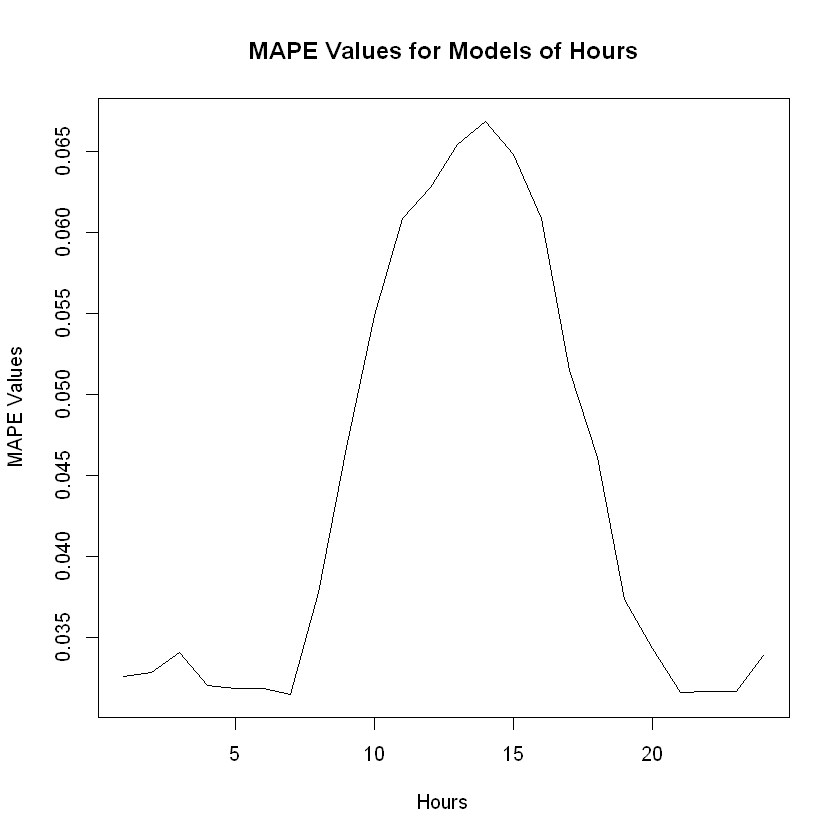

In [42]:
plot(mape_result_c,type="l",ylab="MAPE Values",xlab="Hours",main="MAPE Values for Models of Hours")

In [43]:
C_all_val=c(MAPE0c_reg_values,MAPE1c_reg_values,MAPE2c_reg_values,MAPE3c_reg_values,MAPE4c_reg_values,MAPE5c_reg_values,
           MAPE6c_reg_values,MAPE7c_reg_values,MAPE8c_reg_values,MAPE9c_reg_values,MAPE10c_reg_values,MAPE11c_reg_values,
           MAPE12c_reg_values,MAPE13c_reg_values,MAPE14c_reg_values,MAPE15c_reg_values,MAPE16c_reg_values,MAPE17c_reg_values,
           MAPE18c_reg_values,MAPE19c_reg_values,MAPE20c_reg_values,MAPE21c_reg_values,MAPE22c_reg_values,MAPE23c_reg_values)

# PART D

In [44]:
cont=copy(dt)

## Lag Creator Function

In [45]:
lag_creator<-function(DT, names){   
    hours=c(0:23)
    for (which_hour in hours){
        new_col<-paste0(names,which_hour)
        which_hour=which_hour+1
        DT[,(new_col):=shift(DT[,2],type="lag",n=which_hour)]                
  
        }  
    return(DT[])
}

## Feature Matrix Creator

In [46]:
feature_mat<-function(DT,names){
    feat_mat=data.table(date=seq.POSIXt(from = as.POSIXct("2016-01-01"),to = as.POSIXct("2020-12-01"),by="day"))
    hours=c(0:23)    
    for (which_hour in hours){
    new_col<-paste0(names,which_hour)
    feat_mat[,(new_col):=0]                
    } 
    for(whic_date in seq.POSIXt(from = as.POSIXct("2016-01-01"),to = as.POSIXct("2020-12-01"),by="day")){
        current_DT=filter(DT,date==as.POSIXct(whic_date, origin = "1970-01-01"))
        print(current_DT)
        for(which_hour in hours){
            feat_mat[date==as.POSIXct(whic_date, origin = "1970-01-01"), 
                     feat_mat[,which_hour+1]:=current_DT[hour==which_hour,consumption]] 
        }   
    }
    return(feat_mat[])
}

## Column Name Creator

In [47]:
col_name<-function(DT, names){   
    hours=c(0:23)
    for (which_hour in hours){
        new_col<-paste0(names,which_hour)
        setnames(DT,old=as.character(which_hour),new=as.character(new_col))              
        }  
}

In [48]:
cont<-cont[-2068]
#cont[2060:2080]

In [49]:
data_wide <- spread(cont, hour, consumption)
lag_2=copy(data_wide[,date:=date+2])
col_name(lag_2,"Lag_day2_hour_")
lag_2

date,Lag_day2_hour_0,Lag_day2_hour_1,Lag_day2_hour_2,Lag_day2_hour_3,Lag_day2_hour_4,Lag_day2_hour_5,Lag_day2_hour_6,Lag_day2_hour_7,Lag_day2_hour_8,...,Lag_day2_hour_14,Lag_day2_hour_15,Lag_day2_hour_16,Lag_day2_hour_17,Lag_day2_hour_18,Lag_day2_hour_19,Lag_day2_hour_20,Lag_day2_hour_21,Lag_day2_hour_22,Lag_day2_hour_23
2016-01-03,26277.24,24991.82,23532.61,22464.78,22002.91,21957.08,22203.54,21844.16,23094.73,...,29548.32,29390.89,30734.97,32048.02,31438.11,30728.47,30166.14,29461.28,29242.83,28069.09
2016-01-04,26224.60,24708.58,23771.58,22921.29,22870.89,23325.63,23604.98,24022.70,26930.48,...,32796.18,32594.55,33358.47,34387.95,33591.26,32648.83,31897.73,31049.20,30906.43,29621.09
2016-01-05,27613.96,25779.28,24566.31,23878.42,23511.38,23672.32,23827.08,23405.11,24638.72,...,31056.47,30979.53,32297.46,33462.96,33151.03,32450.21,32093.93,31315.16,31014.19,29462.06
2016-01-06,27103.09,25439.84,24395.07,23961.03,23860.63,24418.47,25708.59,27455.39,32982.07,...,39661.98,39211.00,39760.12,39633.29,37621.41,35954.18,35114.12,34066.40,33686.83,31733.54
2016-01-07,29244.38,27637.23,26335.78,25870.23,25975.07,26318.48,27109.29,28570.22,33106.00,...,38086.11,37834.89,38599.34,38669.63,36954.78,35306.11,34301.59,33400.82,33359.37,31629.97
2016-01-08,29189.27,27614.02,26578.97,25719.19,25864.63,25918.59,27091.94,28533.05,33203.34,...,36847.22,36433.88,37581.09,37304.52,35832.00,34499.94,33670.00,32931.12,32913.06,31450.65
2016-01-09,28763.95,27284.84,26321.95,25748.49,25636.58,25932.52,26963.74,28444.83,32804.27,...,37376.83,37100.43,37668.65,37906.99,35841.62,34621.65,33784.72,32638.14,32739.98,31092.87
2016-01-10,28602.02,27112.37,25975.34,25315.55,25128.15,25356.22,26338.72,28086.42,32702.24,...,36555.58,36190.41,37031.72,37773.70,35930.69,34710.46,33907.65,33048.69,33220.16,32021.60
2016-01-11,29906.93,28061.98,26808.78,25798.80,25820.46,26035.77,26451.24,26853.42,30627.32,...,33524.80,32951.39,33655.89,35045.14,34407.27,33494.32,32624.31,32097.79,32176.63,30760.17
2016-01-12,28890.37,27133.75,25656.13,24937.87,24538.16,24616.05,24478.14,23813.35,24676.92,...,29089.83,29447.75,30569.07,32006.15,31706.26,31305.87,30870.26,30462.79,30537.75,28857.66


In [50]:
data_wide <- spread(cont, hour, consumption)
lag_7=copy(data_wide[,date:=date+7])
col_name(lag_7,"Lag_day7_hour_")
lag_7

date,Lag_day7_hour_0,Lag_day7_hour_1,Lag_day7_hour_2,Lag_day7_hour_3,Lag_day7_hour_4,Lag_day7_hour_5,Lag_day7_hour_6,Lag_day7_hour_7,Lag_day7_hour_8,...,Lag_day7_hour_14,Lag_day7_hour_15,Lag_day7_hour_16,Lag_day7_hour_17,Lag_day7_hour_18,Lag_day7_hour_19,Lag_day7_hour_20,Lag_day7_hour_21,Lag_day7_hour_22,Lag_day7_hour_23
2016-01-08,26277.24,24991.82,23532.61,22464.78,22002.91,21957.08,22203.54,21844.16,23094.73,...,29548.32,29390.89,30734.97,32048.02,31438.11,30728.47,30166.14,29461.28,29242.83,28069.09
2016-01-09,26224.60,24708.58,23771.58,22921.29,22870.89,23325.63,23604.98,24022.70,26930.48,...,32796.18,32594.55,33358.47,34387.95,33591.26,32648.83,31897.73,31049.20,30906.43,29621.09
2016-01-10,27613.96,25779.28,24566.31,23878.42,23511.38,23672.32,23827.08,23405.11,24638.72,...,31056.47,30979.53,32297.46,33462.96,33151.03,32450.21,32093.93,31315.16,31014.19,29462.06
2016-01-11,27103.09,25439.84,24395.07,23961.03,23860.63,24418.47,25708.59,27455.39,32982.07,...,39661.98,39211.00,39760.12,39633.29,37621.41,35954.18,35114.12,34066.40,33686.83,31733.54
2016-01-12,29244.38,27637.23,26335.78,25870.23,25975.07,26318.48,27109.29,28570.22,33106.00,...,38086.11,37834.89,38599.34,38669.63,36954.78,35306.11,34301.59,33400.82,33359.37,31629.97
2016-01-13,29189.27,27614.02,26578.97,25719.19,25864.63,25918.59,27091.94,28533.05,33203.34,...,36847.22,36433.88,37581.09,37304.52,35832.00,34499.94,33670.00,32931.12,32913.06,31450.65
2016-01-14,28763.95,27284.84,26321.95,25748.49,25636.58,25932.52,26963.74,28444.83,32804.27,...,37376.83,37100.43,37668.65,37906.99,35841.62,34621.65,33784.72,32638.14,32739.98,31092.87
2016-01-15,28602.02,27112.37,25975.34,25315.55,25128.15,25356.22,26338.72,28086.42,32702.24,...,36555.58,36190.41,37031.72,37773.70,35930.69,34710.46,33907.65,33048.69,33220.16,32021.60
2016-01-16,29906.93,28061.98,26808.78,25798.80,25820.46,26035.77,26451.24,26853.42,30627.32,...,33524.80,32951.39,33655.89,35045.14,34407.27,33494.32,32624.31,32097.79,32176.63,30760.17
2016-01-17,28890.37,27133.75,25656.13,24937.87,24538.16,24616.05,24478.14,23813.35,24676.92,...,29089.83,29447.75,30569.07,32006.15,31706.26,31305.87,30870.26,30462.79,30537.75,28857.66


In [51]:
dt_with_lag2=merge(cont,lag_2,by.x="date",by.y="date",all.x=TRUE)

In [52]:
full_dt=merge(dt_with_lag2,lag_7,by.x="date",by.y="date",all.x=TRUE)

In [53]:
full_dt %>% relocate(consumption, .after = last_col())
#full_dt

date,hour,Lag_day2_hour_0,Lag_day2_hour_1,Lag_day2_hour_2,Lag_day2_hour_3,Lag_day2_hour_4,Lag_day2_hour_5,Lag_day2_hour_6,Lag_day2_hour_7,...,Lag_day7_hour_15,Lag_day7_hour_16,Lag_day7_hour_17,Lag_day7_hour_18,Lag_day7_hour_19,Lag_day7_hour_20,Lag_day7_hour_21,Lag_day7_hour_22,Lag_day7_hour_23,consumption
2016-01-01,0,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,26277.24
2016-01-01,1,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,24991.82
2016-01-01,2,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,23532.61
2016-01-01,3,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,22464.78
2016-01-01,4,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,22002.91
2016-01-01,5,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,21957.08
2016-01-01,6,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,22203.54
2016-01-01,7,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,21844.16
2016-01-01,8,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,23094.73
2016-01-01,9,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,25202.27


In [54]:
train_d=filter(full_dt,date<="2020-10-31")
#train

In [55]:
test_d=filter(full_dt,date>"2020-10-31")
#test

In [56]:
names_train<-paste0("train_d",0:23)
names_test<-paste0("test_d",0:23)

In [57]:
train_split <- split(train_d, train_d$hour)
new_names_train <- names_train
for (i in 1:length(train_split)) {
  assign(new_names_train[i], train_split[[i]])
}

In [58]:
test_split <- split(test_d, test_d$hour)
new_names_test <- names_test
for (i in 1:length(test_split)) {
  assign(new_names_test[i], test_split[[i]])
}

## Model Training

In [59]:
#print(cvfit$name)
#print(cvfit$glmnet.fit)
#print(cvfit$lambda.1se)
#print(cvfit$lambda.min)
#plot(cvfit)
#coef(cvfit,s="lambda.min")
#coef(cvfit,s="lambda.1se")

In [60]:
mape_result_d=rep(0,24)

In [61]:
set.seed(44)

In [62]:
train_mat0=as.matrix(train_d0[complete.cases(train_d0),-c('date',"hour","consumption"),with=F])
train_mat1=as.matrix(train_d1[complete.cases(train_d1),-c('date',"hour","consumption"),with=F])
train_mat2=as.matrix(train_d2[complete.cases(train_d2),-c('date',"hour","consumption"),with=F])
train_mat3=as.matrix(train_d3[complete.cases(train_d3),-c('date',"hour","consumption"),with=F])
train_mat4=as.matrix(train_d4[complete.cases(train_d4),-c('date',"hour","consumption"),with=F])
train_mat5=as.matrix(train_d5[complete.cases(train_d5),-c('date',"hour","consumption"),with=F])
train_mat6=as.matrix(train_d6[complete.cases(train_d6),-c('date',"hour","consumption"),with=F])
train_mat7=as.matrix(train_d7[complete.cases(train_d7),-c('date',"hour","consumption"),with=F])
train_mat8=as.matrix(train_d8[complete.cases(train_d8),-c('date',"hour","consumption"),with=F])
train_mat9=as.matrix(train_d9[complete.cases(train_d9),-c('date',"hour","consumption"),with=F])
train_mat10=as.matrix(train_d10[complete.cases(train_d10),-c('date',"hour","consumption"),with=F])
train_mat11=as.matrix(train_d11[complete.cases(train_d11),-c('date',"hour","consumption"),with=F])
train_mat12=as.matrix(train_d12[complete.cases(train_d12),-c('date',"hour","consumption"),with=F])
train_mat13=as.matrix(train_d13[complete.cases(train_d13),-c('date',"hour","consumption"),with=F])
train_mat14=as.matrix(train_d14[complete.cases(train_d14),-c('date',"hour","consumption"),with=F])
train_mat15=as.matrix(train_d15[complete.cases(train_d15),-c('date',"hour","consumption"),with=F])
train_mat16=as.matrix(train_d16[complete.cases(train_d16),-c('date',"hour","consumption"),with=F])
train_mat17=as.matrix(train_d17[complete.cases(train_d17),-c('date',"hour","consumption"),with=F])
train_mat18=as.matrix(train_d18[complete.cases(train_d18),-c('date',"hour","consumption"),with=F])
train_mat19=as.matrix(train_d19[complete.cases(train_d19),-c('date',"hour","consumption"),with=F])
train_mat20=as.matrix(train_d20[complete.cases(train_d20),-c('date',"hour","consumption"),with=F])
train_mat21=as.matrix(train_d21[complete.cases(train_d21),-c('date',"hour","consumption"),with=F])
train_mat22=as.matrix(train_d22[complete.cases(train_d22),-c('date',"hour","consumption"),with=F])
train_mat23=as.matrix(train_d23[complete.cases(train_d23),-c('date',"hour","consumption"),with=F])

In [63]:
result_vec0=as.vector(t(train_d0[complete.cases(train_d0),"consumption"]))
result_vec1=as.vector(t(train_d1[complete.cases(train_d1),"consumption"]))
result_vec2=as.vector(t(train_d2[complete.cases(train_d2),"consumption"]))
result_vec3=as.vector(t(train_d3[complete.cases(train_d3),"consumption"]))
result_vec4=as.vector(t(train_d4[complete.cases(train_d4),"consumption"]))
result_vec5=as.vector(t(train_d5[complete.cases(train_d5),"consumption"]))
result_vec6=as.vector(t(train_d6[complete.cases(train_d6),"consumption"]))
result_vec7=as.vector(t(train_d7[complete.cases(train_d7),"consumption"]))
result_vec8=as.vector(t(train_d8[complete.cases(train_d8),"consumption"]))
result_vec9=as.vector(t(train_d9[complete.cases(train_d9),"consumption"]))
result_vec10=as.vector(t(train_d10[complete.cases(train_d10),"consumption"]))
result_vec11=as.vector(t(train_d11[complete.cases(train_d11),"consumption"]))
result_vec12=as.vector(t(train_d12[complete.cases(train_d12),"consumption"]))
result_vec13=as.vector(t(train_d13[complete.cases(train_d13),"consumption"]))
result_vec14=as.vector(t(train_d14[complete.cases(train_d14),"consumption"]))
result_vec15=as.vector(t(train_d15[complete.cases(train_d15),"consumption"]))
result_vec16=as.vector(t(train_d16[complete.cases(train_d16),"consumption"]))
result_vec17=as.vector(t(train_d17[complete.cases(train_d17),"consumption"]))
result_vec18=as.vector(t(train_d18[complete.cases(train_d18),"consumption"]))
result_vec19=as.vector(t(train_d19[complete.cases(train_d19),"consumption"]))
result_vec20=as.vector(t(train_d20[complete.cases(train_d20),"consumption"]))
result_vec21=as.vector(t(train_d21[complete.cases(train_d21),"consumption"]))
result_vec22=as.vector(t(train_d22[complete.cases(train_d22),"consumption"]))
result_vec23=as.vector(t(train_d23[complete.cases(train_d23),"consumption"]))

In [64]:
cvfit0=cv.glmnet(train_mat0,result_vec0,family='gaussian',nfolds = 10,type.measure="mae")
cvfit1=cv.glmnet(train_mat1,result_vec1,family='gaussian',nfolds = 10,type.measure="mae")
cvfit2=cv.glmnet(train_mat2,result_vec2,family='gaussian',nfolds = 10,type.measure="mae")
cvfit3=cv.glmnet(train_mat3,result_vec3,family='gaussian',nfolds = 10,type.measure="mae")
cvfit4=cv.glmnet(train_mat4,result_vec4,family='gaussian',nfolds = 10,type.measure="mae")
cvfit5=cv.glmnet(train_mat5,result_vec5,family='gaussian',nfolds = 10,type.measure="mae")
cvfit6=cv.glmnet(train_mat6,result_vec6,family='gaussian',nfolds = 10,type.measure="mae")
cvfit7=cv.glmnet(train_mat7,result_vec7,family='gaussian',nfolds = 10,type.measure="mae")
cvfit8=cv.glmnet(train_mat8,result_vec8,family='gaussian',nfolds = 10,type.measure="mae")
cvfit9=cv.glmnet(train_mat9,result_vec9,family='gaussian',nfolds = 10,type.measure="mae")
cvfit10=cv.glmnet(train_mat10,result_vec10,family='gaussian',nfolds = 10,type.measure="mae")
cvfit11=cv.glmnet(train_mat11,result_vec11,family='gaussian',nfolds = 10,type.measure="mae")
cvfit12=cv.glmnet(train_mat12,result_vec12,family='gaussian',nfolds = 10,type.measure="mae")
cvfit13=cv.glmnet(train_mat13,result_vec13,family='gaussian',nfolds = 10,type.measure="mae")
cvfit14=cv.glmnet(train_mat14,result_vec14,family='gaussian',nfolds = 10,type.measure="mae")
cvfit15=cv.glmnet(train_mat15,result_vec15,family='gaussian',nfolds = 10,type.measure="mae")
cvfit16=cv.glmnet(train_mat16,result_vec16,family='gaussian',nfolds = 10,type.measure="mae")
cvfit17=cv.glmnet(train_mat17,result_vec17,family='gaussian',nfolds = 10,type.measure="mae")
cvfit18=cv.glmnet(train_mat18,result_vec18,family='gaussian',nfolds = 10,type.measure="mae")
cvfit19=cv.glmnet(train_mat19,result_vec19,family='gaussian',nfolds = 10,type.measure="mae")
cvfit20=cv.glmnet(train_mat20,result_vec20,family='gaussian',nfolds = 10,type.measure="mae")
cvfit21=cv.glmnet(train_mat21,result_vec21,family='gaussian',nfolds = 10,type.measure="mae")
cvfit22=cv.glmnet(train_mat22,result_vec22,family='gaussian',nfolds = 10,type.measure="mae")
cvfit23=cv.glmnet(train_mat23,result_vec23,family='gaussian',nfolds = 10,type.measure="mae")

In [65]:
test_mat0=as.matrix(test_d0[complete.cases(test_d0),-c('date',"hour","consumption")])
test_mat1=as.matrix(test_d1[complete.cases(test_d1),-c('date',"hour","consumption")])
test_mat2=as.matrix(test_d2[complete.cases(test_d2),-c('date',"hour","consumption")])
test_mat3=as.matrix(test_d3[complete.cases(test_d3),-c('date',"hour","consumption")])
test_mat4=as.matrix(test_d4[complete.cases(test_d4),-c('date',"hour","consumption")])
test_mat5=as.matrix(test_d5[complete.cases(test_d5),-c('date',"hour","consumption")])
test_mat6=as.matrix(test_d6[complete.cases(test_d6),-c('date',"hour","consumption")])
test_mat7=as.matrix(test_d7[complete.cases(test_d7),-c('date',"hour","consumption")])
test_mat8=as.matrix(test_d8[complete.cases(test_d8),-c('date',"hour","consumption")])
test_mat9=as.matrix(test_d9[complete.cases(test_d9),-c('date',"hour","consumption")])
test_mat10=as.matrix(test_d10[complete.cases(test_d10),-c('date',"hour","consumption")])
test_mat11=as.matrix(test_d11[complete.cases(test_d11),-c('date',"hour","consumption")])
test_mat12=as.matrix(test_d12[complete.cases(test_d12),-c('date',"hour","consumption")])
test_mat13=as.matrix(test_d13[complete.cases(test_d13),-c('date',"hour","consumption")])
test_mat14=as.matrix(test_d14[complete.cases(test_d14),-c('date',"hour","consumption")])
test_mat15=as.matrix(test_d15[complete.cases(test_d15),-c('date',"hour","consumption")])
test_mat16=as.matrix(test_d16[complete.cases(test_d16),-c('date',"hour","consumption")])
test_mat17=as.matrix(test_d17[complete.cases(test_d17),-c('date',"hour","consumption")])
test_mat18=as.matrix(test_d18[complete.cases(test_d18),-c('date',"hour","consumption")])
test_mat19=as.matrix(test_d19[complete.cases(test_d19),-c('date',"hour","consumption")])
test_mat20=as.matrix(test_d20[complete.cases(test_d20),-c('date',"hour","consumption")])
test_mat21=as.matrix(test_d21[complete.cases(test_d21),-c('date',"hour","consumption")])
test_mat22=as.matrix(test_d22[complete.cases(test_d22),-c('date',"hour","consumption")])
test_mat23=as.matrix(test_d23[complete.cases(test_d23),-c('date',"hour","consumption")])

In [66]:
lasso_model0 <- glmnet(train_mat0,result_vec0, alpha = 1, lambda = cvfit0$lambda.min, standardize = FALSE)
lasso_model1 <- glmnet(train_mat1,result_vec1, alpha = 1, lambda = cvfit1$lambda.min, standardize = FALSE)
lasso_model2 <- glmnet(train_mat2,result_vec2, alpha = 1, lambda = cvfit2$lambda.min, standardize = FALSE)
lasso_model3 <- glmnet(train_mat3,result_vec3, alpha = 1, lambda = cvfit3$lambda.min, standardize = FALSE)
lasso_model4 <- glmnet(train_mat4,result_vec4, alpha = 1, lambda = cvfit4$lambda.min, standardize = FALSE)
lasso_model5 <- glmnet(train_mat5,result_vec5, alpha = 1, lambda = cvfit5$lambda.min, standardize = FALSE)
lasso_model6 <- glmnet(train_mat6,result_vec6, alpha = 1, lambda = cvfit6$lambda.min, standardize = FALSE)
lasso_model7 <- glmnet(train_mat7,result_vec7, alpha = 1, lambda = cvfit7$lambda.min, standardize = FALSE)
lasso_model8 <- glmnet(train_mat8,result_vec8, alpha = 1, lambda = cvfit8$lambda.min, standardize = FALSE)
lasso_model9 <- glmnet(train_mat9,result_vec9, alpha = 1, lambda = cvfit9$lambda.min, standardize = FALSE)
lasso_model10 <- glmnet(train_mat10,result_vec10, alpha = 1, lambda = cvfit10$lambda.min, standardize = FALSE)
lasso_model11 <- glmnet(train_mat11,result_vec11, alpha = 1, lambda = cvfit11$lambda.min, standardize = FALSE)
lasso_model12 <- glmnet(train_mat12,result_vec12, alpha = 1, lambda = cvfit12$lambda.min, standardize = FALSE)
lasso_model13 <- glmnet(train_mat13,result_vec13, alpha = 1, lambda = cvfit13$lambda.min, standardize = FALSE)
lasso_model14 <- glmnet(train_mat14,result_vec14, alpha = 1, lambda = cvfit14$lambda.min, standardize = FALSE)
lasso_model15 <- glmnet(train_mat15,result_vec15, alpha = 1, lambda = cvfit15$lambda.min, standardize = FALSE)
lasso_model16 <- glmnet(train_mat16,result_vec16, alpha = 1, lambda = cvfit16$lambda.min, standardize = FALSE)
lasso_model17 <- glmnet(train_mat17,result_vec17, alpha = 1, lambda = cvfit17$lambda.min, standardize = FALSE)
lasso_model18 <- glmnet(train_mat18,result_vec18, alpha = 1, lambda = cvfit18$lambda.min, standardize = FALSE)
lasso_model19 <- glmnet(train_mat19,result_vec19, alpha = 1, lambda = cvfit19$lambda.min, standardize = FALSE)
lasso_model20 <- glmnet(train_mat20,result_vec20, alpha = 1, lambda = cvfit20$lambda.min, standardize = FALSE)
lasso_model21 <- glmnet(train_mat21,result_vec21, alpha = 1, lambda = cvfit21$lambda.min, standardize = FALSE)
lasso_model22 <- glmnet(train_mat22,result_vec22, alpha = 1, lambda = cvfit22$lambda.min, standardize = FALSE)
lasso_model23 <- glmnet(train_mat23,result_vec23, alpha = 1, lambda = cvfit23$lambda.min, standardize = FALSE)

In [67]:
predicts_hour0 <- predict(lasso_model0, s = cvfit0$lambda.min, newx = test_mat0)
predicts_hour1 <- predict(lasso_model1, s = cvfit1$lambda.min, newx = test_mat1)
predicts_hour2 <- predict(lasso_model2, s = cvfit2$lambda.min, newx = test_mat2)
predicts_hour3 <- predict(lasso_model3, s = cvfit3$lambda.min, newx = test_mat3)
predicts_hour4 <- predict(lasso_model4, s = cvfit4$lambda.min, newx = test_mat4)
predicts_hour5 <- predict(lasso_model5, s = cvfit5$lambda.min, newx = test_mat5)
predicts_hour6 <- predict(lasso_model6, s = cvfit6$lambda.min, newx = test_mat6)
predicts_hour7 <- predict(lasso_model7, s = cvfit7$lambda.min, newx = test_mat7)
predicts_hour8 <- predict(lasso_model8, s = cvfit8$lambda.min, newx = test_mat8)
predicts_hour9 <- predict(lasso_model9, s = cvfit9$lambda.min, newx = test_mat9)
predicts_hour10 <- predict(lasso_model10, s = cvfit10$lambda.min, newx = test_mat10)
predicts_hour11 <- predict(lasso_model11, s = cvfit11$lambda.min, newx = test_mat11)
predicts_hour12 <- predict(lasso_model12, s = cvfit12$lambda.min, newx = test_mat12)
predicts_hour13 <- predict(lasso_model13, s = cvfit13$lambda.min, newx = test_mat13)
predicts_hour14 <- predict(lasso_model14, s = cvfit14$lambda.min, newx = test_mat14)
predicts_hour15 <- predict(lasso_model15, s = cvfit15$lambda.min, newx = test_mat15)
predicts_hour16 <- predict(lasso_model16, s = cvfit16$lambda.min, newx = test_mat16)
predicts_hour17 <- predict(lasso_model17, s = cvfit17$lambda.min, newx = test_mat17)
predicts_hour18 <- predict(lasso_model18, s = cvfit18$lambda.min, newx = test_mat18)
predicts_hour19 <- predict(lasso_model19, s = cvfit19$lambda.min, newx = test_mat19)
predicts_hour20 <- predict(lasso_model20, s = cvfit20$lambda.min, newx = test_mat20)
predicts_hour21 <- predict(lasso_model21, s = cvfit21$lambda.min, newx = test_mat21)
predicts_hour22 <- predict(lasso_model22, s = cvfit22$lambda.min, newx = test_mat22)
predicts_hour23 <- predict(lasso_model23, s = cvfit23$lambda.min, newx = test_mat23)

In [68]:
mape_result_d[1] <- MAPE(test_d0$consumption, predicts_hour0)
mape_result_d[2] <- MAPE(test_d1$consumption, predicts_hour1)
mape_result_d[3] <- MAPE(test_d2$consumption, predicts_hour2)
mape_result_d[4] <- MAPE(test_d3$consumption, predicts_hour3)
mape_result_d[5] <- MAPE(test_d4$consumption, predicts_hour4)
mape_result_d[6] <- MAPE(test_d5$consumption, predicts_hour5)
mape_result_d[7] <- MAPE(test_d6$consumption, predicts_hour6)
mape_result_d[8] <- MAPE(test_d7$consumption, predicts_hour7)
mape_result_d[9] <- MAPE(test_d8$consumption, predicts_hour8)
mape_result_d[10] <- MAPE(test_d9$consumption, predicts_hour9)
mape_result_d[11] <- MAPE(test_d10$consumption, predicts_hour10)
mape_result_d[12] <- MAPE(test_d11$consumption, predicts_hour11)
mape_result_d[13] <- MAPE(test_d12$consumption, predicts_hour12)
mape_result_d[14] <- MAPE(test_d13$consumption, predicts_hour13)
mape_result_d[15] <- MAPE(test_d14$consumption, predicts_hour14)
mape_result_d[16] <- MAPE(test_d15$consumption, predicts_hour15)
mape_result_d[17] <- MAPE(test_d16$consumption, predicts_hour16)
mape_result_d[18] <- MAPE(test_d17$consumption, predicts_hour17)
mape_result_d[19] <- MAPE(test_d18$consumption, predicts_hour18)
mape_result_d[20] <- MAPE(test_d19$consumption, predicts_hour19)
mape_result_d[21] <- MAPE(test_d20$consumption, predicts_hour20)
mape_result_d[22] <- MAPE(test_d21$consumption, predicts_hour21)
mape_result_d[23] <- MAPE(test_d22$consumption, predicts_hour22)
mape_result_d[24] <- MAPE(test_d23$consumption, predicts_hour23)
mape_result_d

[1] 0.01455807 0.01631394 0.01550136 0.01464305 0.01556806 0.01510754
 [7] 0.01783068 0.01867744 0.02569502 0.03645528 0.04176977 0.04436668
[13] 0.04831592 0.04677993 0.04487301 0.03974106 0.03063476 0.02201486
[19] 0.01719507 0.01632995 0.01702599 0.01725580 0.01663471 0.01881853

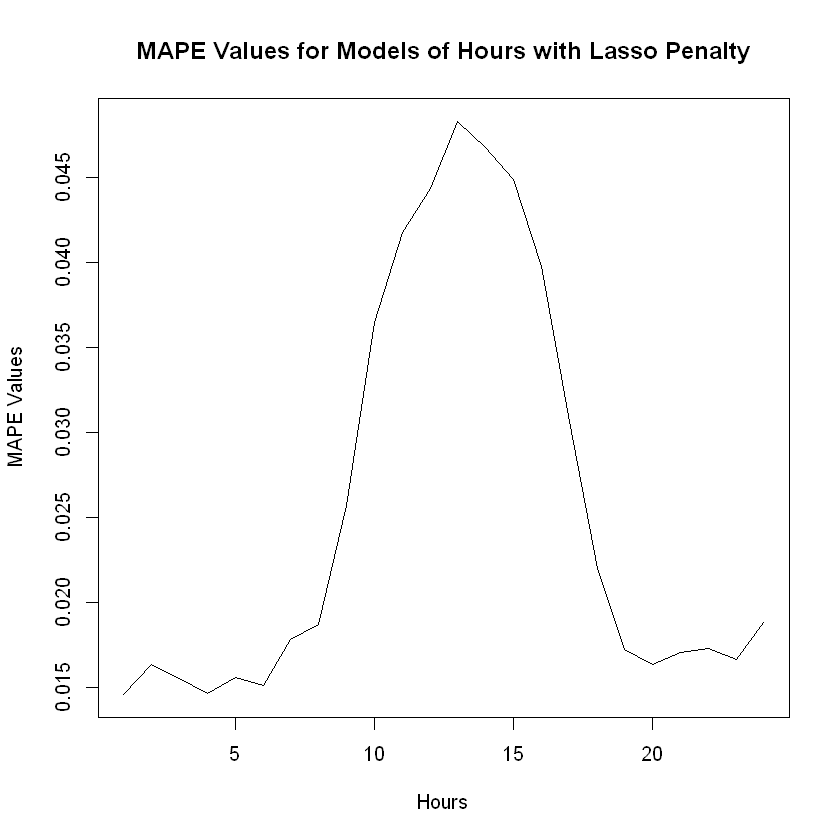

In [69]:
plot(mape_result_d,type="l",ylab="MAPE Values",xlab="Hours",main="MAPE Values for Models of Hours with Lasso Penalty")

In [84]:
MAPE0d_reg_values=as.vector(abs(((hour0_test$consumption-predicts_hour0)/predicts_hour0)))
MAPE1d_reg_values=as.vector(abs(((hour1_test$consumption-predicts_hour1)/predicts_hour1)))
MAPE2d_reg_values=as.vector(abs(((hour2_test$consumption-predicts_hour2)/predicts_hour2)))
MAPE3d_reg_values=as.vector(abs(((hour3_test$consumption-predicts_hour3)/predicts_hour3)))
MAPE4d_reg_values=as.vector(abs(((hour4_test$consumption-predicts_hour4)/predicts_hour4)))
MAPE5d_reg_values=as.vector(abs(((hour5_test$consumption-predicts_hour5)/predicts_hour5)))
MAPE6d_reg_values=as.vector(abs(((hour6_test$consumption-predicts_hour6)/predicts_hour6)))
MAPE7d_reg_values=as.vector(abs(((hour7_test$consumption-predicts_hour7)/predicts_hour7)))
MAPE8d_reg_values=as.vector(abs(((hour8_test$consumption-predicts_hour8)/predicts_hour8)))
MAPE9d_reg_values=as.vector(abs(((hour9_test$consumption-predicts_hour9)/predicts_hour9)))
MAPE10d_reg_values=as.vector(abs(((hour10_test$consumption-predicts_hour10)/predicts_hour10)))
MAPE11d_reg_values=as.vector(abs(((hour11_test$consumption-predicts_hour11)/predicts_hour11)))
MAPE12d_reg_values=as.vector(abs(((hour12_test$consumption-predicts_hour12)/predicts_hour12)))
MAPE13d_reg_values=as.vector(abs(((hour13_test$consumption-predicts_hour13)/predicts_hour13)))
MAPE14d_reg_values=as.vector(abs(((hour14_test$consumption-predicts_hour14)/predicts_hour14)))
MAPE15d_reg_values=as.vector(abs(((hour15_test$consumption-predicts_hour15)/predicts_hour15)))
MAPE16d_reg_values=as.vector(abs(((hour16_test$consumption-predicts_hour16)/predicts_hour16)))
MAPE17d_reg_values=as.vector(abs(((hour17_test$consumption-predicts_hour17)/predicts_hour17)))
MAPE18d_reg_values=as.vector(abs(((hour18_test$consumption-predicts_hour18)/predicts_hour18)))
MAPE19d_reg_values=as.vector(abs(((hour19_test$consumption-predicts_hour19)/predicts_hour19)))
MAPE20d_reg_values=as.vector(abs(((hour20_test$consumption-predicts_hour20)/predicts_hour20)))
MAPE21d_reg_values=as.vector(abs(((hour21_test$consumption-predicts_hour21)/predicts_hour21)))
MAPE22d_reg_values=as.vector(abs(((hour22_test$consumption-predicts_hour22)/predicts_hour22)))
MAPE23d_reg_values=as.vector(abs(((hour23_test$consumption-predicts_hour23)/predicts_hour23)))


In [85]:
D_all_val=c(MAPE0d_reg_values,MAPE1d_reg_values,MAPE2d_reg_values,MAPE3d_reg_values,MAPE4d_reg_values,MAPE5d_reg_values,
           MAPE6d_reg_values,MAPE7d_reg_values,MAPE8d_reg_values,MAPE9d_reg_values,MAPE10d_reg_values,MAPE11d_reg_values,
           MAPE12d_reg_values,MAPE13d_reg_values,MAPE14d_reg_values,MAPE15d_reg_values,MAPE16d_reg_values,MAPE17d_reg_values,
           MAPE18d_reg_values,MAPE19d_reg_values,MAPE20d_reg_values,MAPE21d_reg_values,MAPE22d_reg_values,MAPE23d_reg_values)

# Part E

# Part F

In [94]:
library(ggthemes)

In [86]:
MAPE_hourly=(MAPE_0+MAPE_1+MAPE_2+MAPE_3+MAPE_4+MAPE_5+MAPE_6+MAPE_7+MAPE_8+MAPE_9+
            MAPE_10+MAPE_11+MAPE_12+MAPE_13+MAPE_14+MAPE_15+MAPE_16+MAPE_17+MAPE_18+MAPE_19+
            MAPE_20+MAPE_21+MAPE_22+MAPE_23)/24

print(paste("MAPE values for Lag_168 results(PART A):",MAPE_168))
print(paste("MAPE values for Lag_48 results(PART A):",MAPE_48))
print(paste("MAPE values for Regression model results(PART B):",MAPE_reg))
print(paste("MAPE values(average of all hour) for hourly results(PART C):",MAPE_hourly))
print(paste("MAPE values for Part D results(PART D):",mean(mape_result_d)))

[1] "MAPE values for Lag_168 results(PART A): 0.0365111250910964"
[1] "MAPE values for Lag_48 results(PART A): 0.0818808509914842"
[1] "MAPE values for Regression model results(PART B): 0.0422942770625392"
[1] "MAPE values(average of all hour) for hourly results(PART C): 0.0435714852319661"
[1] "MAPE values for Part D results(PART D): 0.0255044369447535"


In [111]:
MAPE_dt=data.table("MAPE of Lag 48"=MAPE_48_values,"MAPE of Lag 168"=MAPE_168_values,"MAPE of Regr."=MAPE_reg_values,"MAPE of Seasonality"=C_all_val ,"MAPE of Lasso"=D_all_val)
melted_dt=melt(MAPE_dt)

Warning message in melt.data.table(MAPE_dt):
"To be consistent with reshape2's melt, id.vars and measure.vars are internally guessed when both are 'NULL'. All non-numeric/integer/logical type columns are considered id.vars, which in this case are columns []. Consider providing at least one of 'id' or 'measure' vars in future."

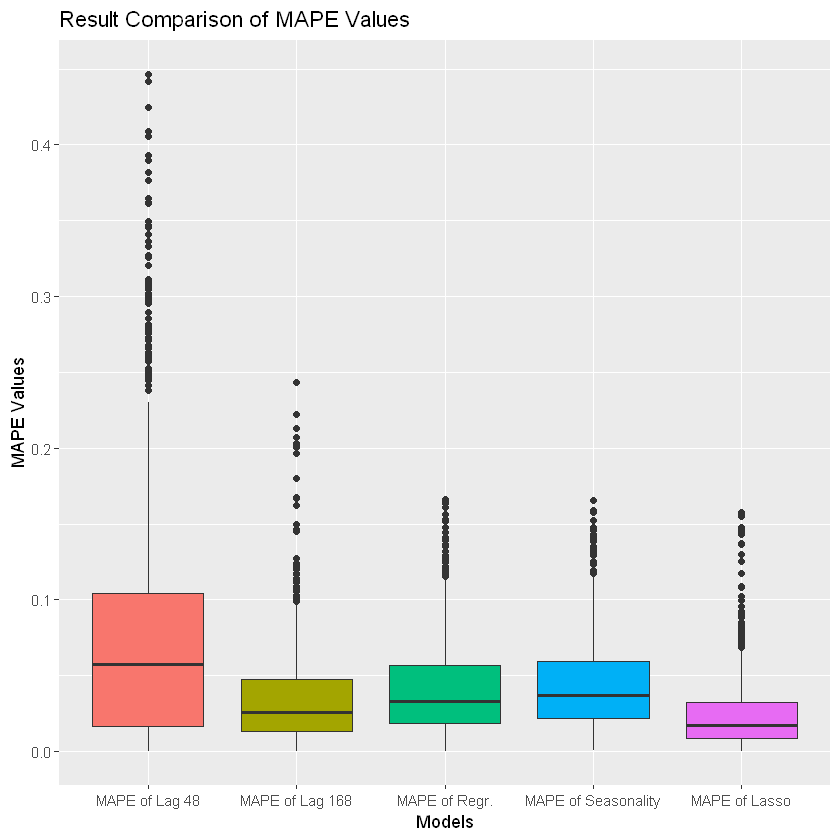

In [127]:
ggplot(melted_dt,aes(x=variable,y=value,fill=variable))+geom_boxplot(position=position_dodge())+
        theme(legend.position = "none")+ggtitle("Result Comparison of MAPE Values")+xlab("Models")+ylab("MAPE Values")